In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pandarallel import pandarallel
from matplotlib import pyplot as plt

In [2]:
pandarallel.initialize(nb_workers=25, progress_bar=False)

INFO: Pandarallel will run on 25 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
data = pd.read_csv("train_w_areas_st_till_june.csv", index_col=0)
data.head()

,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
0,1420,88068,astrophys,Smilei0,tornado,70,1960,10-00:00:00,2021-08-11T16:53:04,2021-09-17T09:46:21,1-11:27:29,1,CANCELLED by 50260,0:0
1,52951,3414,phys,v149_td,tornado,2,56,14-00:00:00,2021-08-18T10:38:10,2021-08-18T10:46:12,14-00:00:38,1,TIMEOUT,0:0
2,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:50:05,2021-08-18T14:50:05,13-21:05:40,1,CANCELLED by 50341,0:0
3,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:52:31,2021-08-18T14:52:32,13-21:04:39,1,CANCELLED by 50341,0:0
4,70802,33028,energ,dcss.slurm,tornado-k40,1,1,14-00:00:00,2021-08-19T15:33:49,2021-08-19T15:33:50,14-00:00:04,1,TIMEOUT,0:0


In [4]:
superuser_uid = 0
data["State"] = data.parallel_apply(
    lambda s: s["State"] if ("CANCELLED" not in s["State"] or s["State"].endswith(f"by {superuser_uid}"))
        else f"CANCELLED by {'user' if s['State'].endswith(str(s['UID'])) else 'smb another'}", 
    axis=1
)

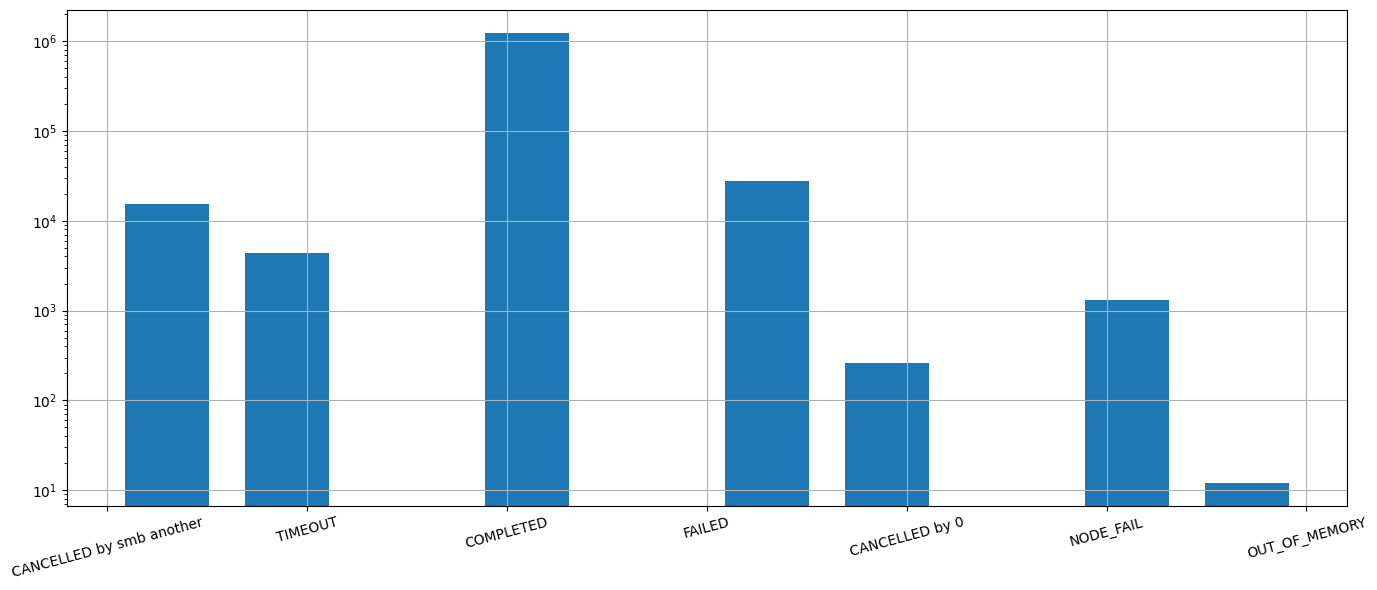

In [5]:
data["State"].hist(figsize=(14, 6), log=True, align='mid', rwidth=0.7, xrot=15)
plt.tight_layout()
plt.show()

In [6]:
data["State"].value_counts()

COMPLETED                   1241831
FAILED                        27777
CANCELLED by smb another      15189
TIMEOUT                        4347
NODE_FAIL                      1310
CANCELLED by 0                  263
OUT_OF_MEMORY                    12
Name: State, dtype: int64

<Axes: >

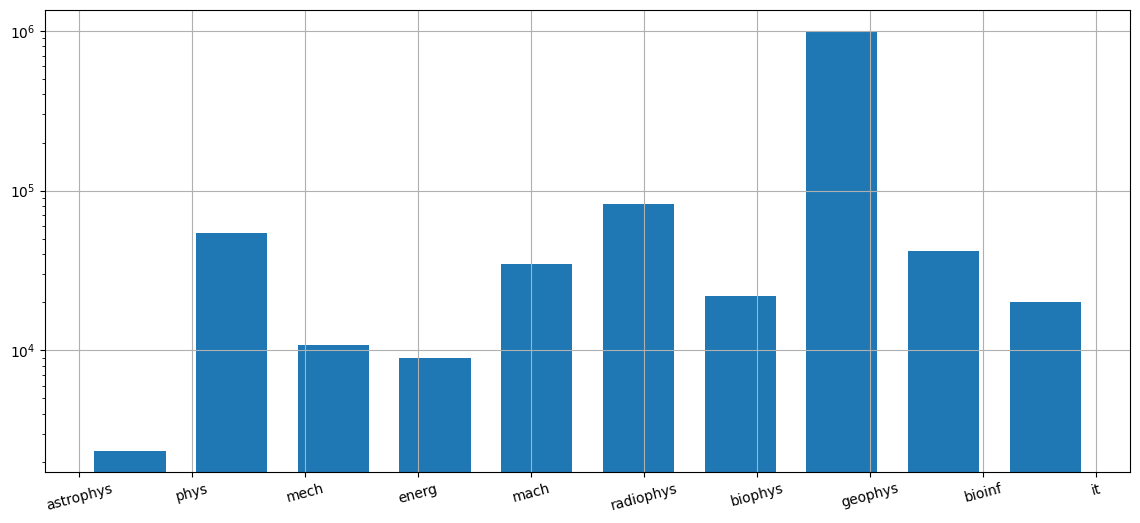

In [7]:
data["Area"].hist(figsize=(14, 6), log=True, align='mid', rwidth=0.7, xrot=15)

In [8]:
data.groupby(["Area"]).count()

,UID,GID,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
Area,,,,,,,,,,,,,
astrophys,2338,2338,2338,2338,2338,2338,2338,2338,2338,2338,2338,2338,2338
bioinf,41840,41840,41840,41840,41840,41840,41840,41840,41840,41840,41840,41840,41840
biophys,21923,21923,21923,21923,21923,21923,21923,21923,21923,21923,21923,21923,21923
energ,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985,8985
geophys,999420,999420,999420,999420,999420,999420,999420,999420,999420,999420,999420,999420,999420
it,20109,20109,20109,20109,20109,20109,20109,20109,20109,20109,20109,20109,20109
mach,34500,34500,34500,34500,34500,34500,34500,34500,34500,34500,34500,34500,34500
mech,10800,10800,10800,10800,10800,10800,10800,10800,10800,10800,10800,10800,10800
phys,54034,54034,54034,54034,54034,54034,54034,54034,54034,54034,54034,54034,54034


In [9]:
tqdm.pandas()

In [10]:
un = data["State"].unique()

def count_cats(df):
    dct = {a: 0 for a in un}
    for _, row in df.iterrows():
        dct[row["State"]] += 1
        
    return pd.Series(dct)

gr = data.groupby("UID").progress_apply(count_cats)
gr

  0%|          | 0/245 [00:00<?, ?it/s]

,CANCELLED by smb another,TIMEOUT,COMPLETED,FAILED,CANCELLED by 0,NODE_FAIL,OUT_OF_MEMORY
UID,,,,,,,
215,0,0,76,0,0,0,0
458,505,13,116,54,0,0,0
1083,8,1,118,7,0,0,0
1310,11,0,431,110,0,0,0
1420,603,13,744,532,3,16,0
...,...,...,...,...,...,...,...
98556,582,247,444,313,4,20,0
99103,505,261,6041,572,0,9,0
99372,0,0,11,0,0,0,0


In [11]:
gr.mean()

CANCELLED by smb another      61.995918
TIMEOUT                       17.742857
COMPLETED                   5068.697959
FAILED                       113.375510
CANCELLED by 0                 1.073469
NODE_FAIL                      5.346939
OUT_OF_MEMORY                  0.048980
dtype: float64

In [12]:
gr.std()

CANCELLED by smb another      141.027741
TIMEOUT                        43.464457
COMPLETED                   25502.757995
FAILED                        309.137347
CANCELLED by 0                  3.813628
NODE_FAIL                      18.087845
OUT_OF_MEMORY                   0.476549
dtype: float64

<BarContainer object of 7 artists>

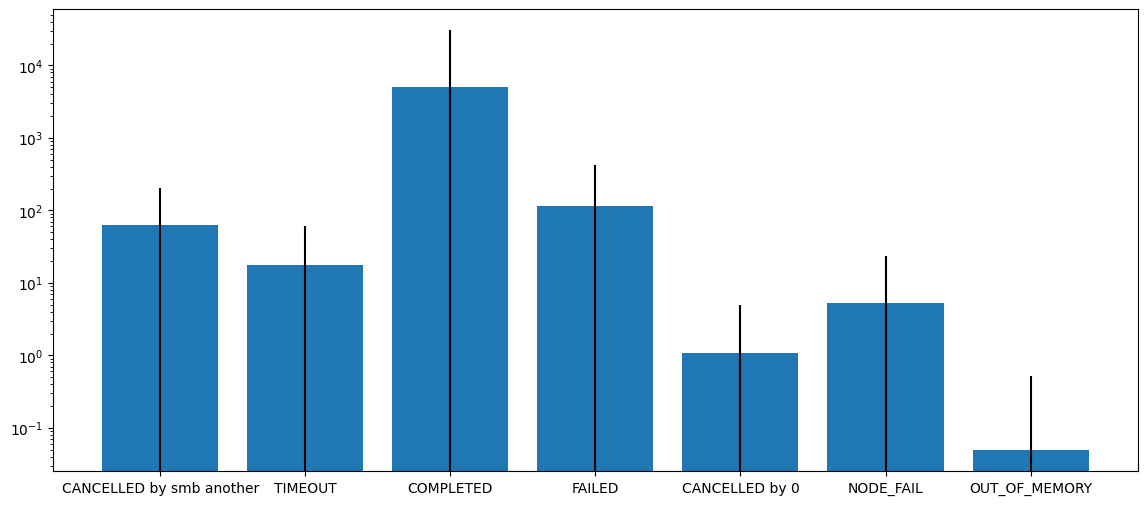

In [13]:
plt.figure(figsize=(14, 6))

plt.bar(gr.columns, gr.mean(), log=True, align='center', yerr=gr.std())

In [14]:
d = data[data["State"] == "COMPLETED"]
d.head()

,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
8,7072,62503,mach,sphere.slrm,tornado,1,1,12-00:00:00,2021-08-22T20:27:50,2021-08-22T22:38:20,11-02:24:32,1,COMPLETED,0:0
9,7072,62503,mach,sphere.slrm,tornado,1,1,14-00:00:00,2021-08-22T20:27:53,2021-08-22T22:38:51,11-02:24:02,1,COMPLETED,0:0
10,6799,22748,mech,espresso_t,tornado,1,1,14-00:00:00,2021-08-23T09:54:28,2021-08-23T09:54:29,12-02:19:27,1,COMPLETED,0:0
11,86601,79320,radiophys,las_batch,tornado,1,1,08:00:00,2021-08-23T09:57:32,2021-08-31T19:52:11,04:11:39,1,COMPLETED,0:0
12,86601,79320,radiophys,las_batch,tornado,1,1,08:00:00,2021-08-23T09:57:32,2021-08-31T19:52:52,04:15:26,1,COMPLETED,0:0


In [15]:
# pd.to_timedelta(d["Elapsed"])
from datetime import timedelta

def parse_elapsed(s: str) -> timedelta:
    if "-" in s:
        days, rest = s.split('-')
        days = int(days)
    else:
        rest = s
        days = 0

    h, m, s = rest.split(":")
    h, m, s = int(h), int(m), int(s)

    return s + m * 60 + h * 60 * 60 + days * 24 * 60 * 60  #timedelta(days=int(days), hours=h, minutes=m, seconds=s)

    d["Elapsed"] = d["Elapsed"].progress_apply(parse_elapsed)  # .dt.
    d["Timelimit"] = d["Timelimit"].progress_apply(parse_elapsed)  # .dt.
d.head()

  0%|          | 0/1241831 [00:00<?, ?it/s]

/tmp/ipykernel_122769/3445388607.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["Elapsed"] = d["Elapsed"].progress_apply(parse_elapsed)  # .dt.


  0%|          | 0/1241831 [00:00<?, ?it/s]

/tmp/ipykernel_122769/3445388607.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["Timelimit"] = d["Timelimit"].progress_apply(parse_elapsed)  # .dt.


,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
8,7072,62503,mach,sphere.slrm,tornado,1,1,1036800,2021-08-22T20:27:50,2021-08-22T22:38:20,959072,1,COMPLETED,0:0
9,7072,62503,mach,sphere.slrm,tornado,1,1,1209600,2021-08-22T20:27:53,2021-08-22T22:38:51,959042,1,COMPLETED,0:0
10,6799,22748,mech,espresso_t,tornado,1,1,1209600,2021-08-23T09:54:28,2021-08-23T09:54:29,1045167,1,COMPLETED,0:0
11,86601,79320,radiophys,las_batch,tornado,1,1,28800,2021-08-23T09:57:32,2021-08-31T19:52:11,15099,1,COMPLETED,0:0
12,86601,79320,radiophys,las_batch,tornado,1,1,28800,2021-08-23T09:57:32,2021-08-31T19:52:52,15326,1,COMPLETED,0:0


In [16]:
gr = dict()
for i in tqdm(['all', 4, 8, 16, 64, 256]):
    if i == 'all':
        gr[i]= d.groupby("UID").progress_apply(lambda df: df["Elapsed"].expanding().mean().shift(1))
    else:
        gr[i]= d.groupby("UID").progress_apply(lambda df: df["Elapsed"].rolling(window=i).mean().shift(1))
        
    
d.set_index("UID", inplace=True)

for uid in tqdm(d.index.unique()):
    for i in gr:
        d.loc[uid, f"mean_elapsed_{i}"] = gr[i].loc[uid].values

d.reset_index(inplace=True)
d.head()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

/tmp/ipykernel_122769/850096306.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[uid, f"mean_elapsed_{i}"] = gr[i].loc[uid].values
/tmp/ipykernel_122769/850096306.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[uid, f"mean_elapsed_{i}"] = gr[i].loc[uid].values
/tmp/ipykernel_122769/850096306.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode,mean_elapsed_all,mean_elapsed_4,mean_elapsed_8,mean_elapsed_16,mean_elapsed_64,mean_elapsed_256
0,7072,62503,mach,sphere.slrm,tornado,1,1,1036800,2021-08-22T20:27:50,2021-08-22T22:38:20,959072,1,COMPLETED,0:0,NaN,NaN,NaN,NaN,NaN,NaN
1,7072,62503,mach,sphere.slrm,tornado,1,1,1209600,2021-08-22T20:27:53,2021-08-22T22:38:51,959042,1,COMPLETED,0:0,959072.0,NaN,NaN,NaN,NaN,NaN
2,6799,22748,mech,espresso_t,tornado,1,1,1209600,2021-08-23T09:54:28,2021-08-23T09:54:29,1045167,1,COMPLETED,0:0,NaN,NaN,NaN,NaN,NaN,NaN
3,86601,79320,radiophys,las_batch,tornado,1,1,28800,2021-08-23T09:57:32,2021-08-31T19:52:11,15099,1,COMPLETED,0:0,NaN,NaN,NaN,NaN,NaN,NaN
4,86601,79320,radiophys,las_batch,tornado,1,1,28800,2021-08-23T09:57:32,2021-08-31T19:52:52,15326,1,COMPLETED,0:0,15099.0,NaN,NaN,NaN,NaN,NaN


In [17]:
d.sort_values(["UID", "Submit"]).head(30)

,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode,mean_elapsed_all,mean_elapsed_4,mean_elapsed_8,mean_elapsed_16,mean_elapsed_64,mean_elapsed_256
708716,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:49:13,1,3838,COMPLETED,0:0,NaN,NaN,NaN,NaN,NaN,NaN
708717,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:49:40,1,3838,COMPLETED,0:0,1.000000,NaN,NaN,NaN,NaN,NaN
708718,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:49:58,1,3838,COMPLETED,0:0,1.000000,NaN,NaN,NaN,NaN,NaN
708719,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:50:10,2,3838,COMPLETED,0:0,1.000000,NaN,NaN,NaN,NaN,NaN
708720,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:50:40,1,3838,COMPLETED,0:0,1.250000,1.25,NaN,NaN,NaN,NaN
708721,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:50:58,1,3838,COMPLETED,0:0,1.200000,1.25,NaN,NaN,NaN,NaN
708722,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:51:10,2,3838,COMPLETED,0:0,1.166667,1.25,NaN,NaN,NaN,NaN
708723,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:51:41,1,3838,COMPLETED,0:0,1.285714,1.50,NaN,NaN,NaN,NaN
708724,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:51:58,1,3838,COMPLETED,0:0,1.250000,1.25,1.250,NaN,NaN,NaN
708725,215,76557,NaN,run.sh,tornado,1,1,604800,2022-09-02T10:49:13,2022-09-02T10:52:11,1,3838,COMPLETED,0:0,1.222222,1.25,1.250,NaN,NaN,NaN


In [18]:
d["Area"].fillna("?", inplace=True)
for c in d.columns:
    if "mean_elapsed" in c:
        d[c].fillna(-1, inplace=True)

d["Submit"] = pd.to_datetime(d["Submit"])

/tmp/ipykernel_122769/817702639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["Area"].fillna("?", inplace=True)
/tmp/ipykernel_122769/817702639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[c].fillna(-1, inplace=True)
/tmp/ipykernel_122769/817702639.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["Submit"] = pd.to_datetime(d["Submit"])


In [19]:
target = "Elapsed"
predict_cols_needed = ["Area", "Partition", "ReqNodes", "ReqCPUS", "Timelimit", "Submit", "Priority", "UID"] + [c for c in d.columns if "mean_elapsed" in c]

def get_train_test_split(data: pd.DataFrame, user_test_frac: float=0.1, uid_col: str = "UID") -> tuple[pd.DataFrame]:
    unique = data[uid_col].unique()
    test_users = np.random.choice(unique, int(user_test_frac * len(unique)))

    test_data = data[data[uid_col].isin(test_users)]
    train_data = data.drop(test_data.index)

    return train_data, test_data


train, test = get_train_test_split(d)

assert len(set(train["UID"].unique()) & set(test["UID"].unique())) == 0

X_train, y_train = train.drop(columns=target)[predict_cols_needed], train[target]
X_test, y_test = test.drop(columns=target)[predict_cols_needed], test[target]

X_train.shape, X_test.shape

((1215837, 14), (25994, 14))

In [20]:
X_train.head()

,Area,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Priority,UID,mean_elapsed_all,mean_elapsed_4,mean_elapsed_8,mean_elapsed_16,mean_elapsed_64,mean_elapsed_256
0,mach,tornado,1,1,1036800,2021-08-22 20:27:50,1,7072,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,mach,tornado,1,1,1209600,2021-08-22 20:27:53,1,7072,959072.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,mech,tornado,1,1,1209600,2021-08-23 09:54:28,1,6799,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,radiophys,tornado,1,1,28800,2021-08-23 09:57:32,1,86601,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,radiophys,tornado,1,1,28800,2021-08-23 09:57:32,1,86601,15099.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [21]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# vectorizer.fit(d["JobName"])

# an = vectorizer.build_analyzer()
# an.func(d["JobName"])

In [41]:
from catboost import CatBoostRegressor

cat_features = ["Area", "Partition"]

model = CatBoostRegressor(
    iterations=450,
    learning_rate=0.1,
    depth=2,
    grow_policy="Depthwise",
    ignored_features=[
        # "ReqNodes", 
        # "ReqCPUS",
        "UID"
    ],
    eval_metric="R2", 
    loss_function="RMSE",
    
    verbose=False
)
model.fit(X_train, y_train, cat_features, eval_set=(X_test, y_test),)
model.score(X_test, y_test)

0.6671895036944845

In [42]:
X, y = d.drop(columns=[target])[predict_cols_needed], d[target]

model = CatBoostRegressor(
    iterations=450,
    learning_rate=0.1,
    depth=2,
    grow_policy="Depthwise",
    ignored_features=[
        # "ReqNodes", 
        # "ReqCPUS",
        "UID"
    ],
    eval_metric="R2", 
    loss_function="RMSE",
    
    verbose=False
)
model.fit(X, y, cat_features)

In [44]:
import pickle

with open("model.PICKLE", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# тестируем класс

import sk_pred
from importlib import reload
reload(sk_pred)

m = sk_pred.SKPredModel()
prepared = m.prepare_df(data)
res = m.predict(prepared)
res

In [87]:
from itertools import product

def product_dict(kwargs):
    keys = kwargs.keys()
    for instance in product(*kwargs.values()):
        yield dict(zip(keys, instance))

In [124]:
pd.concat([X_train.iloc[1], X_train.iloc[2]], axis=1).T

,Area,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Priority,UID,mean_elapsed_all,mean_elapsed_4,mean_elapsed_8,mean_elapsed_16,mean_elapsed_64,mean_elapsed_256
1,mach,tornado,1,1,1209600,2021-08-22 20:27:53,1,7072,959072.0,NaN,NaN,NaN,NaN,NaN
2,mech,tornado,1,1,1209600,2021-08-23 09:54:28,1,6799,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
def my_grid_search(grid, X, y, default_params=None, n_repeat=3):
    if default_params is None:
        default_params = dict()

    best_score = pd.Series({"train": -100, "test": -100})
    best_params = dict()
    scores = dict()

    dd = pd.concat((X, y), axis=1)
    
    train, test = get_train_test_split(dd)

    assert len(set(train["UID"].unique()) & set(test["UID"].unique())) == 0
    
    X_train, y_train = train.drop(columns=target)[predict_cols_needed], train[target]
    X_test, y_test = test.drop(columns=target)[predict_cols_needed], test[target]
    
    for params in tqdm(list(product_dict(grid))):
        print(f"\n\nTry to use params {params}")
        scores_for_params_lst = []
        for n in tqdm(range(n_repeat)):
            m = CatBoostRegressor(**default_params, **params)
    
            m.fit(X_train, y_train)
            score = m.score(X_test, y_test)
    
            scores_for_params_lst.append(pd.Series({
                "train": m.score(X_train, y_train),
                "test": score
            }))

        # print(pd.concat(scores_for_params_lst, axis=1).T)
        mean_score_for_params = pd.concat(scores_for_params_lst, axis=1).T.mean()
        scores[tuple(params.items())] = mean_score_for_params 

        print(f"\nRESULT\nParams: {params}, \nscore: {mean_score_for_params}")

        if score > best_score["test"]:
            best_score = mean_score_for_params
            best_params = params | default_params

        print(f"Current best score is {best_score}")
        

    return CatBoostRegressor(**best_params).fit(X, y), scores, best_score

In [153]:
grid = {
    'learning_rate': [0.1, 0.3, 0.7, 1],
    'depth': [2, 4, 6, 10],
    'l2_leaf_reg': [1, 3, 6, 9],
    "score_function": ["Cosine", "L2", ],
    "iterations": [300, 450, 560, 700],
}

model, scores, best_score = my_grid_search(
    grid, X=X_train, y=y_train, default_params=dict(
    eval_metric="R2", verbose=False, grow_policy="Depthwise", ignored_features=[
        "UID"
    ],
    cat_features=cat_features,
    # iterations=200
    ),
    n_repeat=1
)
                                          

  0%|          | 0/512 [00:00<?, ?it/s]



Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.652501
test     0.504011
dtype: float64
Current best score is train    0.652501
test     0.504011
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.65719
test     0.50301
dtype: float64
Current best score is train    0.652501
test     0.504011
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.660084
test     0.505273
dtype: float64
Current best score is train    0.660084
test     0.505273
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.663049
test     0.506932
dtype: float64
Current best score is train    0.663049
test     0.506932
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.654045
test     0.504596
dtype: float64
Current best score is train    0.663049
test     0.506932
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.658642
test     0.504873
dtype: float64
Current best score is train    0.663049
test     0.506932
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.661224
test     0.505597
dtype: float64
Current best score is train    0.663049
test     0.506932
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.664440
test     0.507732
dtype: float64
Current best score is train    0.664440
test     0.507732
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.652649
test     0.506134
dtype: float64
Current best score is train    0.664440
test     0.507732
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.657139
test     0.506142
dtype: float64
Current best score is train    0.664440
test     0.507732
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.659849
test     0.507733
dtype: float64
Current best score is train    0.659849
test     0.507733
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.662738
test     0.507394
dtype: float64
Current best score is train    0.659849
test     0.507733
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.653781
test     0.508308
dtype: float64
Current best score is train    0.653781
test     0.508308
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.658316
test     0.507851
dtype: float64
Current best score is train    0.653781
test     0.508308
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.660845
test     0.507914
dtype: float64
Current best score is train    0.653781
test     0.508308
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.663772
test     0.509545
dtype: float64
Current best score is train    0.663772
test     0.509545
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.652118
test     0.503994
dtype: float64
Current best score is train    0.663772
test     0.509545
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.656635
test     0.504147
dtype: float64
Current best score is train    0.663772
test     0.509545
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.659031
test     0.502204
dtype: float64
Current best score is train    0.663772
test     0.509545
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.662094
test     0.505724
dtype: float64
Current best score is train    0.663772
test     0.509545
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.652596
test     0.507126
dtype: float64
Current best score is train    0.663772
test     0.509545
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.657257
test     0.510596
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.659960
test     0.509558
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.662700
test     0.509304
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.652216
test     0.504617
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.657089
test     0.504724
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.659212
test     0.503912
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.661904
test     0.505927
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.652375
test     0.504114
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.656897
test     0.504675
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.659497
test     0.503009
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.662113
test     0.504437
dtype: float64
Current best score is train    0.657257
test     0.510596
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.719194
test     0.515394
dtype: float64
Current best score is train    0.719194
test     0.515394
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.734356
test     0.517904
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.744620
test     0.514469
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.754445
test     0.506118
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.722056
test     0.515799
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.738509
test     0.505919
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.746964
test     0.507843
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.756969
test     0.502337
dtype: float64
Current best score is train    0.734356
test     0.517904
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.714343
test     0.519508
dtype: float64
Current best score is train    0.714343
test     0.519508
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.729464
test     0.519761
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.738050
test     0.517992
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.748644
test     0.516669
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.718000
test     0.515006
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.733757
test     0.514964
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.742717
test     0.507651
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.752534
test     0.513703
dtype: float64
Current best score is train    0.729464
test     0.519761
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.711352
test     0.521162
dtype: float64
Current best score is train    0.711352
test     0.521162
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.724605
test     0.523128
dtype: float64
Current best score is train    0.724605
test     0.523128
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.732788
test     0.520122
dtype: float64
Current best score is train    0.724605
test     0.523128
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.742714
test     0.520195
dtype: float64
Current best score is train    0.724605
test     0.523128
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.717737
test     0.518616
dtype: float64
Current best score is train    0.724605
test     0.523128
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.732169
test     0.523184
dtype: float64
Current best score is train    0.732169
test     0.523184
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.741240
test     0.516111
dtype: float64
Current best score is train    0.732169
test     0.523184
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.751463
test     0.511754
dtype: float64
Current best score is train    0.732169
test     0.523184
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.707781
test     0.527762
dtype: float64
Current best score is train    0.707781
test     0.527762
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.722045
test     0.523974
dtype: float64
Current best score is train    0.707781
test     0.527762
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.729457
test     0.518033
dtype: float64
Current best score is train    0.707781
test     0.527762
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.737461
test     0.512178
dtype: float64
Current best score is train    0.707781
test     0.527762
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.714852
test     0.530121
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.729854
test     0.528508
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.738191
test     0.521587
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.746276
test     0.518078
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.799967
test     0.503523
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.823937
test     0.489355
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.838487
test     0.471809
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.852239
test     0.434275
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.806664
test     0.509705
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.831405
test     0.502867
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.845191
test     0.488570
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.857327
test     0.469376
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.788865
test     0.519718
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.810041
test     0.511076
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.822690
test     0.497077
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.835288
test     0.490799
dtype: float64
Current best score is train    0.714852
test     0.530121
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.797541
test     0.532441
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.819927
test     0.521395
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.833833
test     0.504564
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.846539
test     0.496176
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.776540
test     0.526538
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.798499
test     0.531239
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.808713
test     0.532420
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.819606
test     0.524950
dtype: float64
Current best score is train    0.797541
test     0.532441
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.793063
test     0.534225
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.814708
test     0.520401
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.825490
test     0.520788
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.838558
test     0.507794
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.767121
test     0.523015
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.787496
test     0.521520
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.801071
test     0.531497
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.813403
test     0.523974
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.788535
test     0.518561
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.807049
test     0.511232
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.820042
test     0.500432
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.832553
test     0.490539
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.921261
test     0.428897
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.936226
test     0.405983
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.942609
test     0.386943
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.947461
test     0.362202
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.930307
test     0.417481
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.941871
test     0.380841
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.946914
test     0.344647
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.950986
test     0.334554
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.905195
test     0.483989
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.921020
test     0.459736
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.929492
test     0.433495
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.935923
test     0.402368
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.916992
test     0.444189
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.932829
test     0.414682
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.939295
test     0.388134
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.944647
test     0.362762
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.886304
test     0.490081
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.905075
test     0.448563
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.915577
test     0.430461
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.923879
test     0.411679
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.908232
test     0.483172
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.923647
test     0.446426
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.931626
test     0.432710
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.938362
test     0.417511
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.864014
test     0.511841
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.888572
test     0.488178
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.901050
test     0.448414
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.910648
test     0.407231
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.900077
test     0.479779
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.915773
test     0.439836
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.925033
test     0.427800
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.932517
test     0.411347
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.668644
test     0.500053
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.674653
test     0.501325
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.677812
test     0.501286
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.681445
test     0.504009
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.667073
test     0.507810
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.674153
test     0.504227
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.677069
test     0.503649
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.680777
test     0.503947
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.667746
test     0.508004
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.673181
test     0.507681
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.676486
test     0.508791
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.680299
test     0.508557
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.667493
test     0.500931
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.673886
test     0.502191
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.677120
test     0.502152
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.680585
test     0.499619
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.666924
test     0.506437
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.673237
test     0.506884
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.676386
test     0.505801
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.679831
test     0.505257
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.666755
test     0.505597
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.673547
test     0.505322
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.677019
test     0.502202
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.680187
test     0.500983
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.665934
test     0.498315
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.671844
test     0.501559
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.675283
test     0.500890
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.678861
test     0.500317
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.666599
test     0.505003
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.673148
test     0.507625
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.676655
test     0.503908
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.679965
test     0.503577
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.768209
test     0.497257
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.789244
test     0.471304
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.800526
test     0.460888
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.811393
test     0.459542
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.770303
test     0.493826
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.790343
test     0.467132
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.801247
test     0.444418
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.812857
test     0.436061
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.763404
test     0.478944
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.781547
test     0.473840
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.791506
test     0.473378
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.802353
test     0.449940
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.767993
test     0.479516
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.787160
test     0.475216
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.797673
test     0.470299
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.808421
test     0.451706
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.75582
test     0.51167
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.774201
test     0.483055
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.785537
test     0.477786
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.795891
test     0.435696
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.762633
test     0.481093
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.783608
test     0.472469
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.793052
test     0.465926
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.803838
test     0.460373
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.752327
test     0.492732
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.769683
test     0.476932
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.779775
test     0.473239
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.788786
test     0.446015
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.759038
test     0.512372
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.778051
test     0.506146
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.788093
test     0.501949
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.799034
test     0.490965
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.866007
test     0.389025
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.888207
test     0.350536
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.899676
test     0.331105
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.910302
test     0.252893
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.871539
test     0.413183
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.893721
test     0.333573
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.904951
test     0.329698
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.914341
test     0.327302
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.851706
test     0.384788
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.872851
test     0.351961
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.884706
test     0.340742
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.895642
test     0.313548
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.863813
test     0.464558
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.886170
test     0.373859
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.896619
test     0.346529
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.906151
test     0.329850
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.839998
test     0.482840
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.861574
test     0.487703
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.872802
test     0.466378
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.883761
test     0.438268
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.857357
test     0.449162
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.877904
test     0.416237
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.888122
test     0.413595
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.898680
test     0.399335
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.829695
test     0.443009
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.852254
test     0.428893
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.863114
test     0.422982
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.874633
test     0.424841
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.850229
test     0.453429
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.871254
test     0.436704
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.881917
test     0.420957
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.891862
test     0.408653
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.951955
test     0.317770
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.956404
test     0.297578
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.957900
test     0.285496
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.959043
test     0.271943
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.954430
test     0.240698
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.957813
test     0.218165
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.958879
test     0.212341
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.959640
test     0.206354
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.942796
test     0.231025
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.950776
test     0.201380
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.953845
test     0.184736
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.956177
test     0.178672
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.950518
test     0.309254
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.955769
test     0.295370
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.957388
test     0.287841
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.958554
test     0.279469
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.935012
test     0.359276
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.945183
test     0.329569
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.948855
test     0.317121
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.952532
test     0.304621
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.945434
test     0.388814
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.952897
test     0.378103
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.955398
test     0.367187
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.957243
test     0.355282
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.927060
test     0.390794
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.940021
test     0.371969
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.945338
test     0.360821
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.949090
test     0.347882
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.941474
test     0.389527
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.949803
test     0.371851
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.953109
test     0.365673
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.3, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.955381
test     0.359448
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.680587
test     0.481221
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.687782
test     0.485670
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.691423
test     0.487646
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.695502
test     0.488336
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.681245
test     0.489794
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.688329
test     0.494573
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.691995
test     0.497920
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.695878
test     0.501285
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.679865
test     0.491297
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.687203
test     0.490982
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.690969
test     0.493471
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.694839
test     0.495704
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.680277
test     0.498510
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.687307
test     0.493245
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.691656
test     0.498428
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.695778
test     0.499096
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.679274
test     0.506006
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.686062
test     0.502588
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.690019
test     0.503580
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.694261
test     0.501076
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.680229
test     0.495400
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.686822
test     0.498635
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.690490
test     0.497302
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.694738
test     0.500339
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.679213
test     0.503682
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.686131
test     0.503522
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.689955
test     0.502681
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.693689
test     0.498705
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.680016
test     0.502592
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.687112
test     0.504486
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.690794
test     0.499952
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.694466
test     0.498217
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.803796
test     0.389956
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.825061
test     0.176105
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.837538
test     0.162307
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.849927
test     0.141742
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.806930
test     0.272816
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.827729
test     0.115315
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.839427
test     0.113473
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.850791
test     0.055210
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.799832
test     0.362170
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.820052
test     0.332882
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.831099
test     0.324944
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.842114
test     0.326987
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.802231
test     0.342227
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.823101
test     0.258452
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.834481
test     0.257214
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.845020
test     0.085326
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.793743
test     0.433360
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.813749
test     0.429827
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.825559
test     0.400223
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.837273
test     0.359130
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.800976
test     0.420491
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.820372
test     0.411690
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.830954
test     0.414416
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.841849
test     0.368421
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.787915
test     0.421976
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.809084
test     0.394991
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.819304
test     0.385052
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.830521
test     0.335639
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.799071
test     0.465957
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.818578
test     0.450895
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.829567
test     0.441135
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.840145
test     0.427752
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.903309
test     0.268193
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.920596
test     0.221840
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.928095
test     0.179790
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.93536
test     0.16406
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.909092
test     0.081020
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.924847
test     0.051351
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.931679
test    -0.007267
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.937428
test    -0.056257
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.896072
test     0.252126
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.913841
test     0.217730
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.922313
test     0.212548
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.928635
test     0.203015
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.901127
test     0.290358
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.918221
test     0.277864
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.925535
test     0.079069
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.932379
test     0.022041
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.882729
test     0.393523
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.900450
test     0.371156
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.910142
test     0.335351
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.919206
test     0.314408
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.895051
test     0.349260
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.913195
test     0.269983
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.921018
test     0.243403
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.928152
test     0.219156
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.877643
test     0.399613
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.897765
test     0.372315
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.907189
test     0.349856
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.915569
test     0.310151
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.891008
test     0.340591
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.908961
test     0.289962
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.917297
test     0.269807
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.924929
test     0.255901
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.958839
test    -0.069089
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.960074
test    -0.092915
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.960446
test    -0.097540
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.960663
test    -0.100388
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.959428
test     0.101789
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.960362
test     0.086699
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.96064
test     0.07877
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.960813
test     0.076155
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.956613
test     0.192203
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.958817
test     0.174653
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.959617
test     0.168966
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.960160
test     0.161173
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.958230
test     0.189194
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.959744
test     0.171344
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.960226
test     0.165276
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.960564
test     0.162847
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.953588
test     0.354886
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.957168
test     0.345075
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.958448
test     0.337658
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.959320
test     0.331584
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.956866
test     0.198243
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.959050
test     0.189964
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.959751
test     0.184411
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.960281
test     0.181854
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.949432
test     0.278762
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.955017
test     0.252552
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.956951
test     0.248448
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.958365
test     0.243631
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.955648
test     0.307001
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.958487
test     0.286520
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.959318
test     0.282012
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 0.7, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.959911
test     0.277228
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.685455
test     0.463865
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.692984
test     0.461728
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.697278
test     0.455983
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.701595
test     0.461412
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.683897
test     0.474231
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.692389
test     0.471394
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.696429
test     0.473243
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.700971
test     0.471170
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.684674
test     0.490965
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.692529
test     0.482403
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.696331
test     0.481644
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.70074
test     0.47348
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.685548
test     0.499861
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.693375
test     0.497386
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.697680
test     0.492288
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.702177
test     0.480695
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.684807
test     0.488272
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.692586
test     0.489548
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.696732
test     0.494321
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.701189
test     0.489754
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.685525
test     0.497643
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.692973
test     0.497662
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.696941
test     0.497100
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.701447
test     0.492897
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.683725
test     0.486032
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.691485
test     0.475226
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.695676
test     0.479215
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.699884
test     0.468632
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.685457
test     0.499738
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.692976
test     0.499921
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.697083
test     0.500560
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 2, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.701376
test     0.498247
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.817295
test     0.191887
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.839942
test     0.190509
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.851241
test     0.172073
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.861730
test     0.152777
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.819192
test     0.171679
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.839350
test     0.104274
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.850316
test     0.106996
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.861875
test     0.062021
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.811191
test     0.208615
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.832280
test     0.142874
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.843439
test     0.163919
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.855362
test     0.165716
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.812033
test     0.249740
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.833320
test     0.153542
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.844828
test     0.112697
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.856080
test    -0.033162
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.808265
test     0.243928
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.828450
test     0.206416
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.839962
test     0.145575
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.850656
test     0.114256
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.811855
test     0.313751
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.832241
test     0.299553
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.843414
test     0.297903
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.853041
test     0.287139
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.802262
test     0.442462
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.822854
test     0.380478
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.833740
test     0.332317
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.845020
test     0.338451
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.808064
test     0.440188
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.828624
test     0.404180
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.839934
test     0.400752
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 4, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.851068
test     0.377977
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.914585
test    -0.069583
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.929327
test    -0.286530
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.935686
test    -0.486159
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.941204
test    -0.470866
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.914986
test    -0.704545
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.929778
test    -0.832848
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.936415
test    -0.837100
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.941477
test    -0.856118
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.908379
test     0.258202
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.923131
test     0.215676
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.930092
test     0.190827
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.936040
test     0.188181
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.911004
test     0.257346
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.925727
test     0.173121
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.932549
test     0.151798
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.938211
test     0.132204
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.899285
test     0.270020
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.915845
test     0.240609
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.923512
test     0.220207
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.930901
test     0.184211
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.905561
test     0.176897
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.920189
test     0.078427
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.928406
test     0.016097
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.934682
test    -0.051596
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.893815
test     0.336797
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.911584
test     0.265112
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.919995
test     0.223522
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.927481
test     0.208751
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.903522
test     0.074327
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.919287
test     0.036955
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.926406
test     0.003503
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 6, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.932556
test    -0.005157
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.959510
test    -0.098362
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.960204
test    -0.113039
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.960431
test    -0.122434
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.960566
test    -0.122550
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.959881
test    -0.032288
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.960505
test    -0.046821
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.960683
test    -0.050961
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 1, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.960794
test    -0.053727
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.958459
test     0.069075
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.959893
test     0.057072
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.960280
test     0.054656
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.960538
test     0.045600
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.959375
test     0.093696
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.960301
test     0.085708
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.960559
test     0.081822
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 3, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.960743
test     0.076192
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.956952
test     0.170654
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.959067
test     0.158320
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.959739
test     0.155811
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.96022
test     0.14836
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.958661
test     0.224814
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.959867
test     0.210858
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.960273
test     0.206484
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 6, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.96058
test     0.20351
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 300}, 
score: train    0.955052
test     0.207901
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 450}, 
score: train    0.957970
test     0.186921
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 560}, 
score: train    0.959082
test     0.173298
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'Cosine', 'iterations': 700}, 
score: train    0.959805
test     0.164820
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 300}, 
score: train    0.957932
test     0.276263
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 450}, 
score: train    0.959532
test     0.263373
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 560}, 
score: train    0.960086
test     0.257773
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


Try to use params {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}


  0%|          | 0/1 [00:00<?, ?it/s]


RESULT
Params: {'learning_rate': 1, 'depth': 10, 'l2_leaf_reg': 9, 'score_function': 'L2', 'iterations': 700}, 
score: train    0.960453
test     0.254736
dtype: float64
Current best score is train    0.793063
test     0.534225
dtype: float64


In [155]:
model.score(X_test, y_test)

0.14970578263614276

In [161]:
best_score

train    0.793063
test     0.534225
dtype: float64

In [156]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'R2',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 300,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'Depthwise',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 6,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Unifor

In [76]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(cat_features=cat_features, eval_metric="R2", verbose=False, grow_policy="Depthwise")

grid = {
    'learning_rate': [0.1, 0.3, 0.7, 1],
    'depth': [2, 4, 6, 10],
    'l2_leaf_reg': [1, 3, 6, 9],
    "score_function": ["Cosine", "L2", "NewtonL2", "NewtonCosine"],
    "iterations": [300, 450, 560, 700],
}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6266489168
bestIteration = 299

0:	loss: 0.6266489	best: 0.6266489 (0)	total: 14.2s	remaining: 4h 1m 54s

bestTest = 0.6324705104
bestIteration = 299

1:	loss: 0.6324705	best: 0.6324705 (1)	total: 28.3s	remaining: 4h 44s

bestTest = 0.6380175724
bestIteration = 294

2:	loss: 0.6380176	best: 0.6380176 (2)	total: 43.7s	remaining: 4h 7m 39s

bestTest = 0.6360967815
bestIteration = 299

3:	loss: 0.6360968	best: 0.6380176 (2)	total: 58.6s	remaining: 4h 9m 9s

bestTest = 0.6255499895
bestIteration = 299

4:	loss: 0.6255500	best: 0.6380176 (2)	total: 1m 12s	remaining: 4h 6m 40s

bestTest = 0.6318999809
bestIteration = 299

5:	loss: 0.6319000	best: 0.6380176 (2)	total: 1m 26s	remaining: 4h 4m 50s

bestTest = 0.6362382656
bestIteration = 279

6:	loss: 0.6362383	best: 0.6380176 (2)	total: 1m 41s	remaining: 4h 6m 55s

bestTest = 0.6360053768
bestIteration = 299

7:	loss: 0.6360054	best: 0.6380176 (2)	total: 1m 56s	remaining: 4h 7m 32s

bestTest = 0.6248840364
bestIteration = 299

8:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Area'),
  Text(1, 0, 'Partition'),
  Text(2, 0, 'ReqNodes'),
  Text(3, 0, 'ReqCPUS'),
  Text(4, 0, 'Timelimit'),
  Text(5, 0, 'Submit'),
  Text(6, 0, 'Priority'),
  Text(7, 0, 'mean_elapsed_all'),
  Text(8, 0, 'mean_elapsed_4'),
  Text(9, 0, 'mean_elapsed_8'),
  Text(10, 0, 'mean_elapsed_16'),
  Text(11, 0, 'mean_elapsed_64'),
  Text(12, 0, 'mean_elapsed_256')])

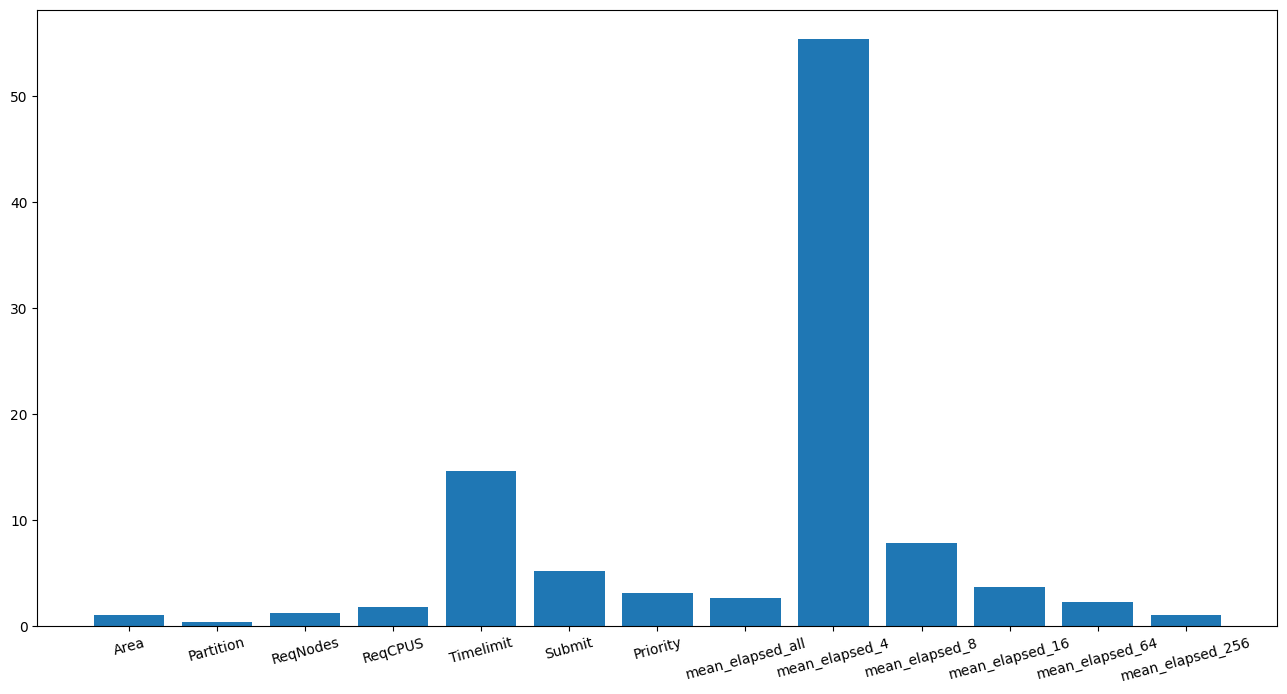

In [80]:
plt.figure(figsize=(16, 8))
plt.bar(X_train.columns, cat.feature_importances_)
plt.xticks(rotation=15)

In [82]:
cat.score(X_train, y_train), cat.score(X_test, y_test)

(0.8712919942734567, 0.47400771904930883)

In [38]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'R2',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 450,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'Depthwise',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 1,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Unifor

In [54]:
import pickle

with open("result.pkl", "wb") as f:
    pickle.dump(cat, f)

with open("result.pkl", "rb") as f:
    res = pickle.load(f)

In [55]:
with open("result.pkl", "rb") as f:
    res = pickle.load(f)

In [58]:
res.score(X_test, y_test)

0.7671349079378806